In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 7)

climbs = (
    pd.read_csv('data/climbs.csv')
    .assign(Route=lambda x:x['Route'].replace('Fuhrers Finger', "Fuhrer's Finger"))
)

# Combining Data: Observations
---

This section covers statistical and computational concerns associated with combining datasets. Broadly, there are two ways to augment a dataset:
1. Extending existing attributes to other observations (e.g. in time or space) is computationally convenient, but raises questions of the scope of the dataset.
1. Adding attributes to existing data creates a richer description of the observations, though the process of associate the new information to each individual observation may be ambiguous.

## Combining similar measurements of different individuals

Datasets are often stored in many different files, for a variety of reasons. Consider a dataset consisting of residential home sales across the United States. There may be:

* One file published every month of the home sales from that month.
* Files published for each County in the United States.
* Home sales split up into files of size 300MB for ease of storage on servers.

In reality, such a dataset would likely be split as some combination of all three possibilities. Each of these needs careful attention is several possible ways: 
* the distributions of what's being measured may change (e.g. the recording of home sales became more reliable over time),
* the meaning of the attributes may vary by what generated the data (e.g. each County reports sales differently),
* the structure of the data itself may differ across files (e.g. a developer changes the data-ingestion code).

While it's easy, memory permitting, to combine many files into a single table, the way in which a dataset is split offers a clue into how the data were recorded. These clues are valuable assets in understanding and assessing the faithfulness of the dataset to the assumptions on how the data were generated.

## Appending data row-wise

In Pandas, the `concat` function combines many similar measurements into a single DataFrame. It takes in a list of DataFrames, aligns their columns, and returns a "horizontally stacked" DataFrame:

In [3]:
df = pd.DataFrame(np.random.randint(0,10, size=(5,4)))
df1, df2, df3 = df.iloc[[0]], df.iloc[[2]], df.iloc[[4]]

In [4]:
df1

,0,1,2,3
0,0,2,5,1


In [5]:
df2

,0,1,2,3
2,2,8,5,1


In [6]:
df3

,0,1,2,3
4,7,7,9,9


In [7]:
dfList = df1, df2, df3
pd.concat(dfList)

,0,1,2,3
0,0,2,5,1
2,2,8,5,1
4,7,7,9,9


**Example:** Suppose a dataset of residential home prices consists of 50 files named `prices_STATEABBR.csv`, where `STATEABBR` is the state abbreviation, each of which have the same format. Loading such a dataset into Pandas would follow the pattern:

In [ ]:
import glob
DIRNAME = 'data/home_prices'
files = glob.glob(DIRNAME)
states = [pd.read_csv(f) for f in files if f[:7] == 'prices_']
prices = pd.concat(states)

*Remark 1:* The module [`glob`](https://docs.python.org/3/library/glob.html) does Unix-style pattern matching.

*Remark 2:* The state each file represents can be attached to the resulting DataFrame by extracting the state abbreviations from the file names and using the `concat` keyword `keys`.

## Application: out-of-core processing via chunking

When a dataset is split over many files for space considerations, it may not be possible to collect the data into a single table. In these cases, it's necessary to process the data one file at a time, while still managing to calculate the desired quantities. Such a 'out-of-core' processing is often tricky.

* Example of multi-file, one at a time (running mean).
* Example of chunking with read_csv.

## Application: Time Series

Assessing data collected continuously in time requires understanding how these datasets change in time. To describe these data, one must first understand how to compute with dates and times.

The data types relevant to time series data in Pandas are timestamps, time-deltas, and time-grouping objects.

### Timestamps

Pandas Timestamps represent a particular moment in time (e.g. Sat 8th, 2019 at 3:00PM). The Pandas Timestamp class are built upon Numpy's [datetime64](https://docs.scipy.org/doc/numpy/reference/arrays.datetime.html) class, which stores a moment in time as the number of seconds (or possibly milliseconds, nanoseconds) since Jan 1, 1970 as a 64 bit integer. This is representation of timestamps is known as [UNIX time](https://en.wikipedia.org/wiki/Unix_time).

*Remark:* Pandas Timestamps differ from Numpy datetime64 objects in one primary way: they can also encode a timezone.

To parse a date and time stored as a string, Pandas has the flexible `to_datetime` function, which:
* Parses a string, or container of strings, to Timestamp objects.
* Automatically infers the format of the date and time represented by the string.

For example,

In [9]:
pd.to_datetime('Sat Sept 7th 2019, 6:38PM')

Timestamp('2019-09-07 18:38:00')

In [10]:
dates = pd.Series(['1/4/2018', '12/31/2017', '3/15/2018'])
pd.to_datetime(dates)

0   2018-01-04
1   2017-12-31
2   2018-03-15
dtype: datetime64[ns]

The format inference can both parse lists of heterogeneous formats:

In [11]:
dates = pd.Series(['1/4/2018', '2017-12-31', 'March 15, 2018'])
pd.to_datetime(dates)

0   2018-01-04
1   2017-12-31
2   2018-03-15
dtype: datetime64[ns]

The format inference also makes a best guess at the true values of underspecified dates and times. For example, simply specifying 'Saturday 2019' results in '2019-01-05', which is the first Saturday of 2019.

In [12]:
pd.to_datetime('Sat 2019 at 3:00PM')

Timestamp('2019-01-05 15:00:00')

The format inference done by the parser both slows down the parsing and struggles with determining ambiguous date formats (e.g. is 8/1/1970 in August or January?). For both correctness and performance, the format should explicitly be passed to `to_datetime` whenever possible!

Below, the format for a date in MONTH/DAY/YEAR is specified by the string `'%m/%d/%Y'`. The full reference for specifying date formats in python may be found in the [documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior), or in this [table](http://strftime.org/).

In [13]:
dates = pd.Series(['1/4/2018', '12/31/2017', '3/15/2018'])
parsed_dates = pd.to_datetime(dates, format='%m/%d/%Y')
parsed_dates

0   2018-01-04
1   2017-12-31
2   2018-03-15
dtype: datetime64[ns]

Timestamps have useful attributes and methods that return values such as the day of the week the timestamp falls on, the number of days in the month of the timestamp, a string representation of the timestamp in a specified format. For a full list, see the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html).

Pandas makes these methods and attributes available through the datetime namespace, accessed as `Series.dt`. For example, to calculate the (name of) day of the week of a column of dates:

In [14]:
parsed_dates.dt.day_name()

0    Thursday
1      Sunday
2    Thursday
dtype: object

**Example:** Parse the dates in the dataset of summit attempts of Mt. Rainier and calculate the distribution of climbers across the days of the week:

In [15]:
climbs_parsed = climbs.assign(ParsedDate=pd.to_datetime(climbs['Date']))

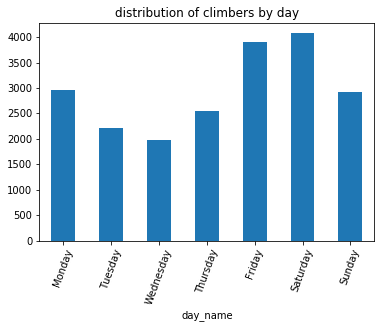

In [16]:
(
    climbs_parsed
    .assign(day_name=climbs_parsed.ParsedDate.dt.day_name())
    .groupby('day_name')['Attempted']
    .sum()
    .loc['Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()] # sort the days
    .plot(kind='bar', rot=70, title='distribution of climbers by day')
);

Friday and Saturday are the most popular days for climbers to start up the mountain, coinciding with weekend trips.

*Remark:* The `dayofweek` method, which returns an integer encoded representation of the day of the week, would also work in this case. This method would eliminate the sorting step, but would be less readable.

### Timedeltas

Time deltas are the difference in times between two timestamps. Subtracting two timestamps results in a Timedelta object:

In [17]:
ts1, ts2 = pd.to_datetime(['1/4/2018 7:31:30 AM', '12/31/2017 8:28:01 PM'])
delta = ts1 - ts2
delta

Timedelta('3 days 11:03:29')

Timedelta objects are defined:
* by adding and substracting Timestamps,
* using the constructor [`Timedelta`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html)
* using the parser [`to_timedelta`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_timedelta.html)

Representing a change in time, Timedeltas may then be added or subtracted to Timestamp objects:

In [18]:
dates = pd.Series(['12/5/2018 12:34:12 AM', '12/31/2018 8:23:14 PM', '3/15/2018 2:12:59 PM'])
parsed_dates = pd.to_datetime(dates)

parsed_dates + delta

0   2018-12-08 11:37:41
1   2019-01-04 07:26:43
2   2018-03-19 01:16:28
dtype: datetime64[ns]

Timedeltas have useful [methods and attributes](https://pandas.pydata.org/pandas-docs/version/0.25/reference/api/pandas.Timedelta.html). For example, the `total_seconds` method converts a time delta to the total number of seconds elapsed:

In [19]:
delta.total_seconds()

299009.0

**Example:** Select all parties that attempted to climb Mt. Rainier within 1 week of June 12, 2015.

In [20]:
ts = pd.to_datetime('June 12 2015')
td = pd.to_timedelta('7 days')
start_ts, end_ts = ts - td, ts + td
    
(
    climbs_parsed
    .loc[
        (climbs_parsed['ParsedDate'] >= start_ts) & 
        (climbs_parsed['ParsedDate'] <= end_ts)
    ]
)

,Date,Route,Attempted,Succeeded,ParsedDate
1232,6/19/2015,Disappointment Cleaver,4,0,2015-06-19
1233,6/19/2015,Ptarmigan Ridge,3,3,2015-06-19
1234,6/19/2015,Disappointment Cleaver,5,5,2015-06-19
...,...,...,...,...,...
1505,6/5/2015,Disappointment Cleaver,12,12,2015-06-05
1506,6/5/2015,Disappointment Cleaver,3,3,2015-06-05
1507,6/5/2015,Kautz Glacier,3,3,2015-06-05


### Grouping data by Time windows

The Pandas `Grouper` allows one to group data by time frequency; this object is then passed to the splitting operation in a Pandas aggregation. Using `Grouper` requires specifying a frequency `freq` and a column `key` on which to group (if a key is omitted, the index is used).

For example, a Grouper object for grouping the dates of climbing attempts on Mt. Rainier would use:

In [21]:
grouper = pd.Grouper(key='ParsedDate', freq='1d')
grouper

TimeGrouper(key='ParsedDate', freq=<Day>, axis=0, sort=True, closed='left', label='left', how='mean', convention='e', base=0)

*Remark:* Notice the `Grouper` object includes detailed attributes of how to defined the time windows. For details, see the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html).

This grouper object can then be used to plot the number of climbers attempting to summit per day:

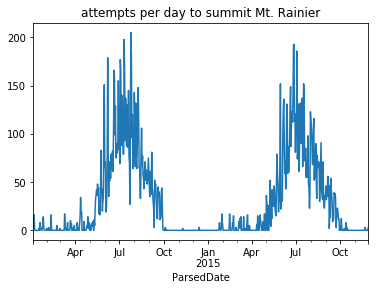

In [22]:
climbs_parsed.groupby(grouper)['Attempted'].sum().plot(title='attempts per day to summit Mt. Rainier');

This aggregation is noisy; the number of attempts varies wildly from day-to-day. For example, recall that there is more activity on the mountain during the weekend. The seasonal trend of when people are climbing Mt. Rainier is clearer when counting attempts by the week:

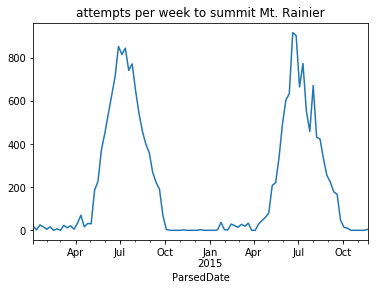

In [23]:
grouper = pd.Grouper(key='ParsedDate', freq='7d')
climbs_parsed.groupby(grouper)['Attempted'].sum().plot(title='attempts per week to summit Mt. Rainier');

**Example:** Grouper objects may also be used in pivot tables. To plot the number of climbers attempting Mt. Ranier every two weeks, for each route:

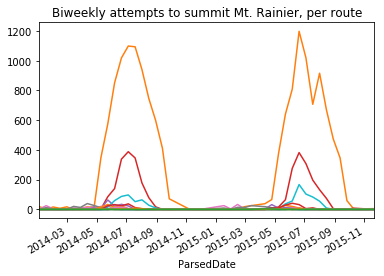

In [24]:
(
    climbs_parsed
    .pivot_table(
        index=pd.Grouper(key='ParsedDate', freq='14d'), 
        columns='Route', 
        values='Attempted', 
        aggfunc='sum', 
        fill_value=0)
    .plot(legend=False, title='Biweekly attempts to summit Mt. Rainier, per route')
);